#1) 패키지설치 및 개발환경 구축

In [ ]:
#구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#tsfm 패키지 설치
!pip install git+https://github.com/IBM/tsfm.git

  Cloning https://github.com/IBM/tsfm.git to /tmp/pip-req-build-jfod2u_0
  Running command git clone --filter=blob:none --quiet https://github.com/IBM/tsfm.git /tmp/pip-req-build-jfod2u_0
  Resolved https://github.com/IBM/tsfm.git to commit 92d3fa2f5c36500bac0c07866c8795b008b6b509
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
#Huggingface의 transformer 라이브러리 설치
!pip install transformers

In [ ]:
#PatchTSMixer ? 불러오기
from transformers import PatchTSMixerConfig
from tsfm_public.toolkit.dataset import ForecastDFDataset
import pandas as pd

In [ ]:
#PatchTsMixer ? 불러오기
import os
import random

from transformers import (
    EarlyStoppingCallback,
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)
import numpy as np
import pandas as pd
import torch

from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index

In [ ]:
#재현성을 위한 랜덤시드 설정
from transformers import set_seed

set_seed(42)

In [ ]:
#데이터 준비 및 모델 환경 설정
import pandas as pd
# Download ECL data from https://github.com/zhouhaoyi/Informer2020
##기존 데이터셋과 다르게, 캡스톤 프로젝트 용 데이터셋 활용
dataset_path = "/content/drive/MyDrive/01/cycling_wExpansion.csv"
timestamp_column = 'Time [s]'
id_columns = []

context_length = 512
forecast_horizon = 96
num_workers = 8  # Reduce this if you have low number of CPU cores
batch_size = 32  # Adjust according to GPU memory


# 2) 데이터 전처리

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA

# 데이터 불러오기
data = pd.read_csv(dataset_path, header=0)
#data=data.iloc[:50000] # for 데이터 개형 확인
print(data.columns)

# 데이터 분리
Time = data.iloc[:, 0]  # Time in seconds
Current = data.iloc[:, 1]  # Current in mA
Voltage = data.iloc[:, 2]  # Voltage in V
Expansion = data.iloc[:, 3]  # Expansion in mu m
Temperature = data.iloc[:, 4]  # Temperature in C
Q = data.iloc[:, 5]  # Q in Ah
Capacity = data.iloc[:, 6]  # Capacity in A.h
cycle_number = data.iloc[:, 7]

print(data.head)

In [ ]:
#방전이 이뤄지는 시점 알아보기
Capacity.index[Capacity < 0.001].tolist()

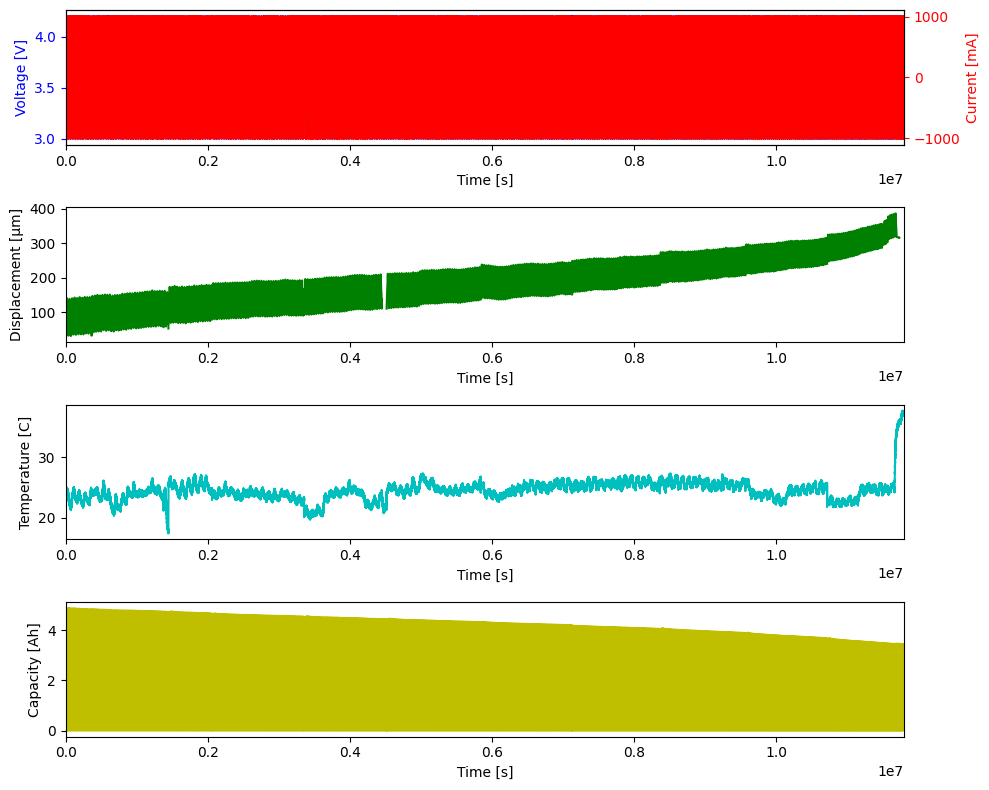

In [ ]:
##시각화
# 그래프 그리기
plt.figure(1, figsize=(10, 8))

# 첫 번째 서브플롯 (전압과 전류)
ax1 = plt.subplot(4, 1, 1)
ax1.plot(Time, Voltage, 'b-', linewidth=1.5)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlim([0, Time.iloc[-1]])

ax2 = ax1.twinx()
ax2.plot(Time, Current, 'r-', linewidth=1.5)
ax2.set_ylabel('Current [mA]', color='r')
ax2.tick_params('y', colors='r')
ax2.set_xlim([0, Time.iloc[-1]])

# 두 번째 서브플롯 (팽창)
plt.subplot(4, 1, 2)
plt.plot(Time, Expansion, 'g-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [μm]')
plt.xlim([0, Time.iloc[-1]])

# 세 번째 서브플롯 (온도)
plt.subplot(4, 1, 3)
plt.plot(Time, Temperature, 'c-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [C]')
plt.xlim([0, Time.iloc[-1]])


# 네 번째 서브플롯 (Capa)
plt.subplot(4, 1, 4)
plt.plot(Time, Capacity, 'y-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Capacity [Ah]')
plt.xlim([0, Time.iloc[-1]])

plt.tight_layout()
plt.show()

Time [s]                0
Current [mA]            0
Voltage [V]             0
Expansion [mu m]    13114
Temperature [C]         0
Q [Ah]                  0
Capacity [Ah]           0
Cycle number            0
dtype: int64


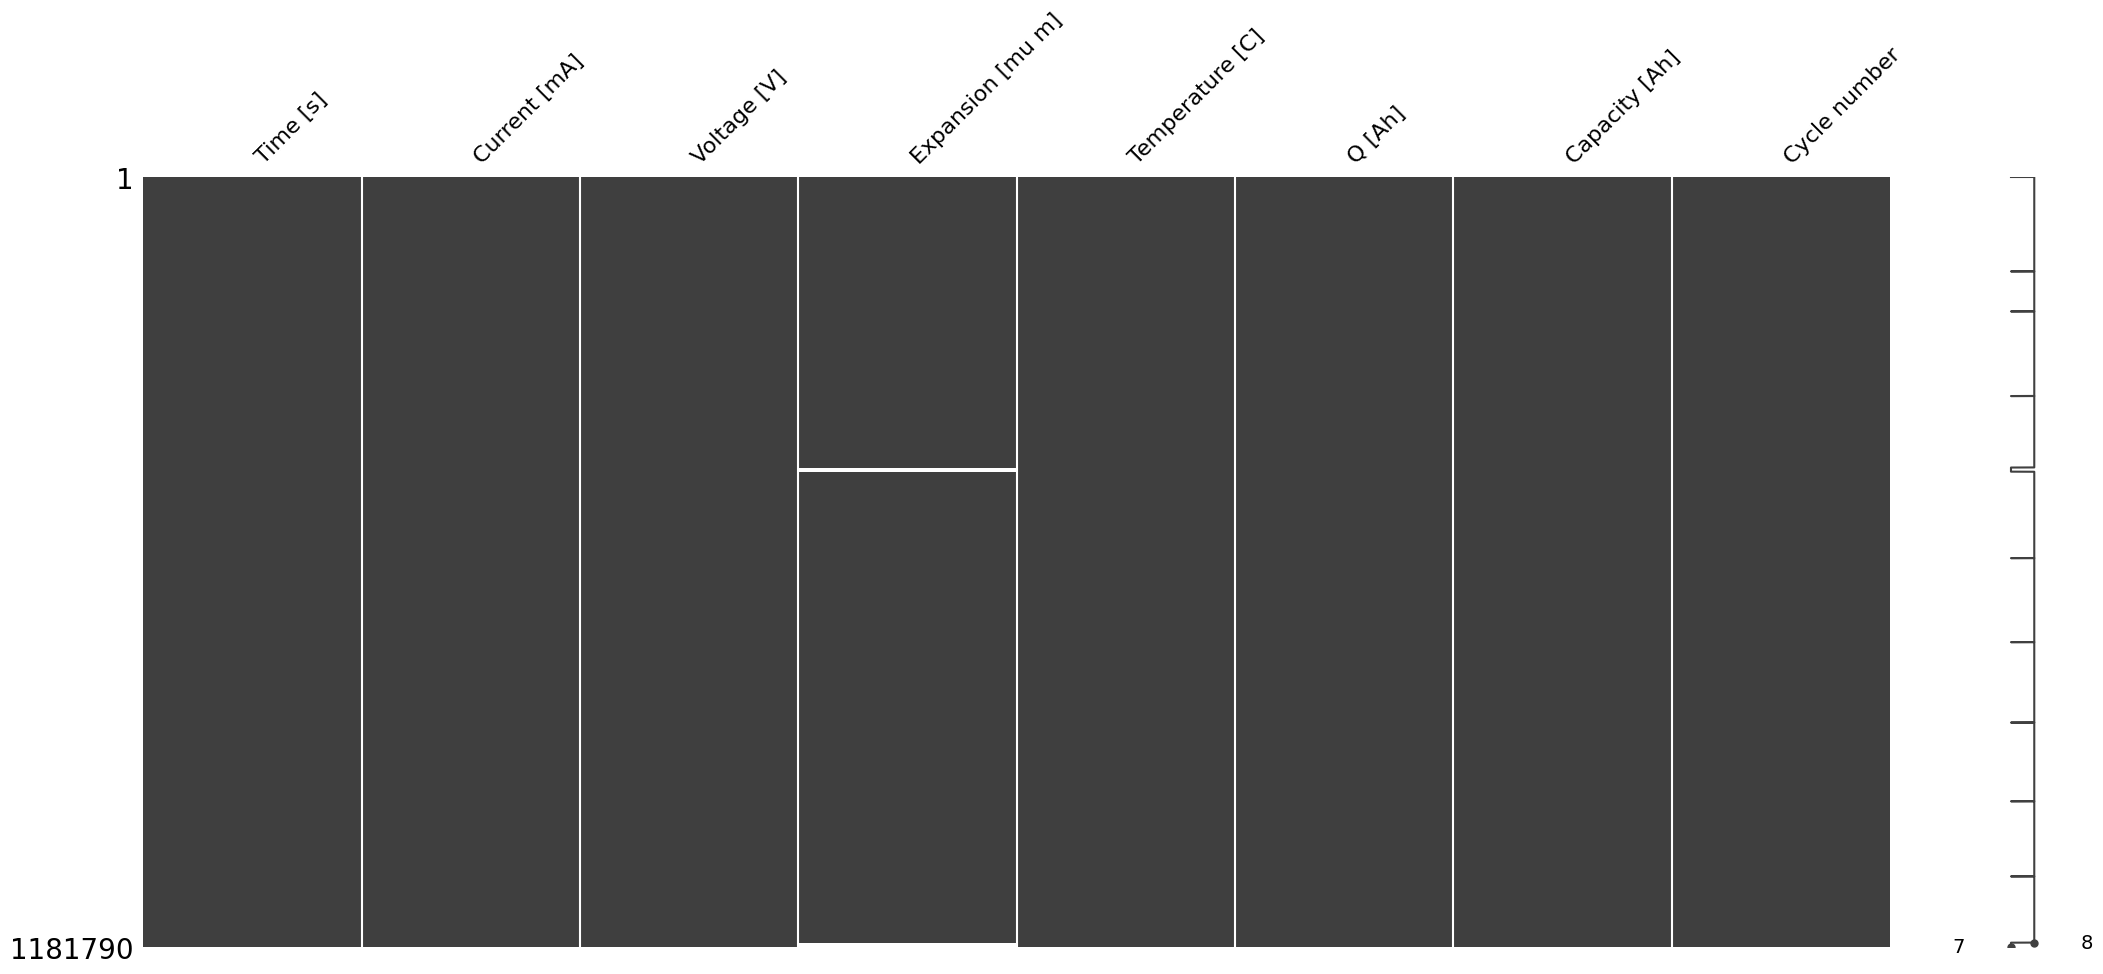

In [ ]:
##결측치 확인
import pandas as pd
import missingno as msno

# missingno 패키지의 matrix 함수를 사용하여 결측치를 시각화합니다.
msno.matrix(data)

#결측치 개수를 확인합니다
print(data.isnull().sum())

In [ ]:
# 각 열에서 결측치를 평균값으로 대체합니다.
data.fillna(data.mean(), inplace=True)
data

,Time [s],Current [mA],Voltage [V],Expansion [mu m],Temperature [C],Q [Ah],Capacity [Ah],Cycle number
0,0.000000e+00,0.00000,3.358494,192.499464,22.832777,0.000000,0.000000,0
1,1.000000e+01,0.00000,3.358455,32.400000,22.896147,0.000000,0.000000,0
2,2.000000e+01,0.00000,3.358416,32.400000,22.991203,0.000000,0.000000,0
3,2.999800e+01,0.00000,3.358494,32.469980,22.864462,0.000000,0.000000,0
4,3.999800e+01,1000.23750,3.384411,32.569980,22.785248,0.002751,0.002751,0
...,...,...,...,...,...,...,...,...
1181785,1.179725e+07,-999.77649,3.055138,192.499464,37.186234,0.413284,3.437950,379
1181786,1.179726e+07,-1001.45130,3.035878,192.499464,37.352581,0.410508,3.440727,379
1181787,1.179727e+07,-998.90955,3.013782,192.499464,37.376347,0.407731,3.443504,379
1181788,1.179728e+07,-999.75677,2.999997,192.499464,37.542694,0.406195,3.445039,379


In [ ]:
#대체 후 결측치 재확인
print(data.isnull().sum())

Time [s]            0
Current [mA]        0
Voltage [V]         0
Expansion [mu m]    0
Temperature [C]     0
Q [Ah]              0
Capacity [Ah]       0
Cycle number        0
dtype: int64


In [ ]:
##데이터 변환
#시점을 실수로 바꾸기
data[timestamp_column] = pd.to_numeric(data[timestamp_column], errors='raise')

#종속변수인 'soh' 추가
data['soh']=0
initial_value = data.iloc[3575, 6]
for i in range(len(data)):
  data.loc[i,'soh']=data.iloc[i,6]/initial_value

#예측에 쓰이는 모든 변수들 설정
forecast_columns = list(data.columns[1:])

# get split
num_train = int(len(data) * 0.7)
num_test = int(len(data) * 0.2)
num_valid = len(data) - num_train - num_test
border1s = [
    0,
    num_train - context_length,
    len(data) - num_test - context_length,
]
border2s = [num_train, num_train + num_valid, len(data)]

train_start_index = border1s[0]  # None indicates beginning of dataset
train_end_index = border2s[0]

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
valid_start_index = border1s[1]
valid_end_index = border2s[1]

test_start_index = border1s[2]
test_end_index = border2s[2]

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
valid_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=valid_start_index,
    end_index=valid_end_index,
)
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)

time_series_processor = TimeSeriesPreprocessor(
    context_length=context_length,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    input_columns=forecast_columns,
    output_columns=forecast_columns,
    target_columns=[forecast_columns[7]],
    control_columns=forecast_columns[:7],
    scaling=True,
)
time_series_processor.train(train_data)


TimeSeriesPreprocessor {
  "categorical_encoder": null,
  "conditional_columns": [],
  "context_length": 512,
  "control_columns": [
    "Current [mA]",
    "Voltage [V]",
    "Expansion [mu m]",
    "Temperature [C]",
    "Q [Ah]",
    "Capacity [Ah]",
    "Cycle number"
  ],
  "encode_categorical": true,
  "feature_extractor_type": "TimeSeriesPreprocessor",
  "freq": "10.00000119023025",
  "frequency_mapping": {
    "10_minutes": 3,
    "15_minutes": 4,
    "half_hourly": 1,
    "hourly": 2,
    "oov": 0
  },
  "id_columns": [],
  "input_columns": [
    "Current [mA]",
    "Voltage [V]",
    "Expansion [mu m]",
    "Temperature [C]",
    "Q [Ah]",
    "Capacity [Ah]",
    "Cycle number",
    "soh"
  ],
  "observable_columns": [],
  "output_columns": [
    "Current [mA]",
    "Voltage [V]",
    "Expansion [mu m]",
    "Temperature [C]",
    "Q [Ah]",
    "Capacity [Ah]",
    "Cycle number",
    "soh"
  ],
  "prediction_length": null,
  "processor_class": "TimeSeriesPreprocessor",
  "s

In [ ]:
#soh값의 동향 파악
print("최대 Capa at 초반 cycle :")
print(data['soh'][3575])
print(data['soh'][7169])
print("최대 Capa at 마지막 cycle:")
print(data['soh'][1176678])
print(data['soh'][1179236])

최대 Capa at 초반 cycle :
1.0
0.9953149215995805
최대 Capa at 마지막 cycle:
0.7058760667043491
0.7046975234741939


In [ ]:
##데이터셋 설정
#훈련 데이터셋
train_dataset = ForecastDFDataset(
    time_series_processor.preprocess(train_data),
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]], #종속변수: soh
    control_columns=forecast_columns[:7], #독립변수: current, voltage 등 8가지
    context_length=context_length,
    prediction_length=forecast_horizon,
)
valid_dataset = ForecastDFDataset(
    time_series_processor.preprocess(valid_data),
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]], #종속변수: soh
    control_columns=forecast_columns[:7], #독립변수: current, voltage 등 8가지
    context_length=context_length,
    prediction_length=forecast_horizon,
)
test_dataset = ForecastDFDataset(
    time_series_processor.preprocess(test_data),
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]], #종속변수: soh
    control_columns=forecast_columns[:7], #독립변수: current, voltage 등 8가지
    context_length=context_length,
    prediction_length=forecast_horizon,
)

#3) 모델 구축 및 훈련

In [ ]:
#모델 구축하기
patch_length = 8
config = PatchTSMixerConfig(
    context_length=context_length,
    prediction_length=forecast_horizon,
    patch_length=patch_length,
    num_input_channels=len(forecast_columns),
    patch_stride=patch_length,
    d_model=16,
    num_layers=8,
    expansion_factor=2,
    dropout=0.2,
    head_dropout=0.2,
    mode="common_channel",
    scaling="std",
)
model = PatchTSMixerForPrediction(config)

In [ ]:
#훈련 시작
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/data01/ouput",
    overwrite_output_dir=True,
    learning_rate=0.1,
    num_train_epochs=1,  # For a quick test of this notebook, set it to 1
    do_eval=True,
    evaluation_strategy="epoch",
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    dataloader_num_workers=num_workers,
    report_to="tensorboard",
    save_strategy="epoch",
    logging_strategy="epoch",
    save_total_limit=3,
    logging_dir="/content/drive/MyDrive/data01/log",  # Make sure to specify a logging directory
    load_best_model_at_end=True,  # Load the best model when training ends
    metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
    greater_is_better=False,  # For loss
    label_names=["future_values"],
)

# Create the early stopping callback
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,  # Number of epochs with no improvement after which to stop
    early_stopping_threshold=0.0001,  # Minimum improvement required to consider as improvement
)

# define trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    callbacks=[early_stopping_callback],
)

# pretrain
trainer.train()

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch,Training Loss,Validation Loss
1,80.610100,0.096649


TrainOutput(global_step=25833, training_loss=80.61008690434716, metrics={'train_runtime': 1056.2946, 'train_samples_per_second': 782.59, 'train_steps_per_second': 24.456, 'total_flos': 5600944020258816.0, 'train_loss': 80.61008690434716, 'epoch': 1.0})

In [ ]:
#훈련 결과 출력
results = trainer.evaluate(test_dataset)
print("Test result:")
print(results)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Test result:
{'eval_loss': 0.09161897003650665, 'eval_runtime': 143.6969, 'eval_samples_per_second': 1644.176, 'eval_steps_per_second': 51.386, 'epoch': 1.0}


In [ ]:
#모델 저장하기
save_dir = "/content/drive/MyDrive/data01/best_model"
os.makedirs(save_dir, exist_ok=True)
trainer.save_model(save_dir)

#4) 미세조정 설정

In [ ]:
import pandas as pd

from tsfm_public.toolkit.dataset import ForecastDFDataset
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index
from transformers import (
    PatchTSMixerConfig,
    PatchTSMixerForPrediction,
    Trainer,
    TrainingArguments,
)

In [ ]:
#데이터셋 불러오기
dataset_path ="/content/drive/MyDrive/01/cycling_wExpansion.csv"
timestamp_column = 'Time [s]'
id_columns = []
prediction_length = 96

#사전학습된 모델 설정
pretrained_model_path = "/content/drive/MyDrive/data01/best_model"

# load pretrained model config, to access some previously defined parameters
pretrained_config = PatchTSMixerConfig.from_pretrained(pretrained_model_path)
context_length = (
    pretrained_config.context_length
)  # use pretrained_config.context_length to match pretrained model

train_start_index = None  # None indicates beginning of dataset
train_end_index = 12 * 30 * 24

# we shift the start of the evaluation period back by context length so that
# the first evaluation timestamp is immediately following the training data
eval_start_index = 12 * 30 * 24 - context_length
eval_end_index = 12 * 30 * 24 + 4 * 30 * 24

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from sklearn.decomposition import PCA

# 데이터 불러오기
data = pd.read_csv(dataset_path, header=0)
#data=data.iloc[:10000] # for 데이터 개형 확인
print(data.columns)
# 데이터 분리
Time = data.iloc[:, 0]  # Time in seconds
Current = data.iloc[:, 1]  # Current in mA
Voltage = data.iloc[:, 2]  # Voltage in V
Expansion = data.iloc[:, 3]  # Expansion in mu m
Temperature = data.iloc[:, 4]  # Temperature in C
Q = data.iloc[:, 5]  # Q in Ah
Capacity = data.iloc[:, 6]  # Capacity in A.h
cycle_number = data.iloc[:, 7]

print(data.head)

Index(['Time [s]', 'Current [mA]', 'Voltage [V]', 'Expansion [mu m]',
       'Temperature [C]', 'Q [Ah]', 'Capacity [Ah]', 'Cycle number'],
      dtype='object')
<bound method NDFrame.head of              Time [s]  Current [mA]  Voltage [V]  Expansion [mu m]  \
0        0.000000e+00       0.00000     3.358494               NaN   
1        1.000000e+01       0.00000     3.358455          32.40000   
2        2.000000e+01       0.00000     3.358416          32.40000   
3        2.999800e+01       0.00000     3.358494          32.46998   
4        3.999800e+01    1000.23750     3.384411          32.56998   
...               ...           ...          ...               ...   
1181785  1.179725e+07    -999.77649     3.055138               NaN   
1181786  1.179726e+07   -1001.45130     3.035878               NaN   
1181787  1.179727e+07    -998.90955     3.013782               NaN   
1181788  1.179728e+07    -999.75677     2.999997               NaN   
1181789  1.179728e+07    -999.67798   

In [ ]:
#충적시작되는 시점 확인
Capacity.index[Capacity < 0.001].tolist()

[0,
 1,
 2,
 3,
 3576,
 7170,
 10756,
 14337,
 17915,
 21488,
 25055,
 28618,
 32179,
 35739,
 39296,
 42850,
 46401,
 49948,
 53494,
 57038,
 60579,
 64115,
 67647,
 71178,
 74708,
 78235,
 81761,
 85285,
 88806,
 92325,
 95841,
 99355,
 102868,
 106378,
 109884,
 113388,
 116891,
 120393,
 123892,
 127389,
 130885,
 134377,
 137867,
 141355,
 144838,
 144839,
 144840,
 144841,
 148324,
 151812,
 155291,
 158765,
 162235,
 165701,
 169164,
 172625,
 176082,
 179537,
 182990,
 186440,
 189888,
 193333,
 196777,
 200218,
 203658,
 206244,
 206245,
 206246,
 206247,
 209672,
 213105,
 216530,
 219951,
 223368,
 226781,
 230191,
 233599,
 237003,
 240406,
 243805,
 247204,
 250600,
 253996,
 257390,
 260782,
 264170,
 267557,
 270942,
 274324,
 277704,
 281084,
 284460,
 287836,
 291210,
 294583,
 297954,
 301323,
 304691,
 308058,
 311423,
 314785,
 318144,
 321502,
 324860,
 328215,
 331569,
 334921,
 336203,
 336204,
 336205,
 336206,
 339562,
 342923,
 346276,
 349622,
 352964,
 35630

In [ ]:
print("최대 Capa at 초반 cycle :")
print(Capacity[3575])
print(Capacity[7169])
print("최대 Capa at 마지막 cycle:")
print(Capacity[1176678])
print(Capacity[1179236])

최대 Capa at 초반 cycle :
4.89715052983646
4.87420699566552
최대 Capa at 마지막 cycle:
3.45678135406008
3.45100985045609


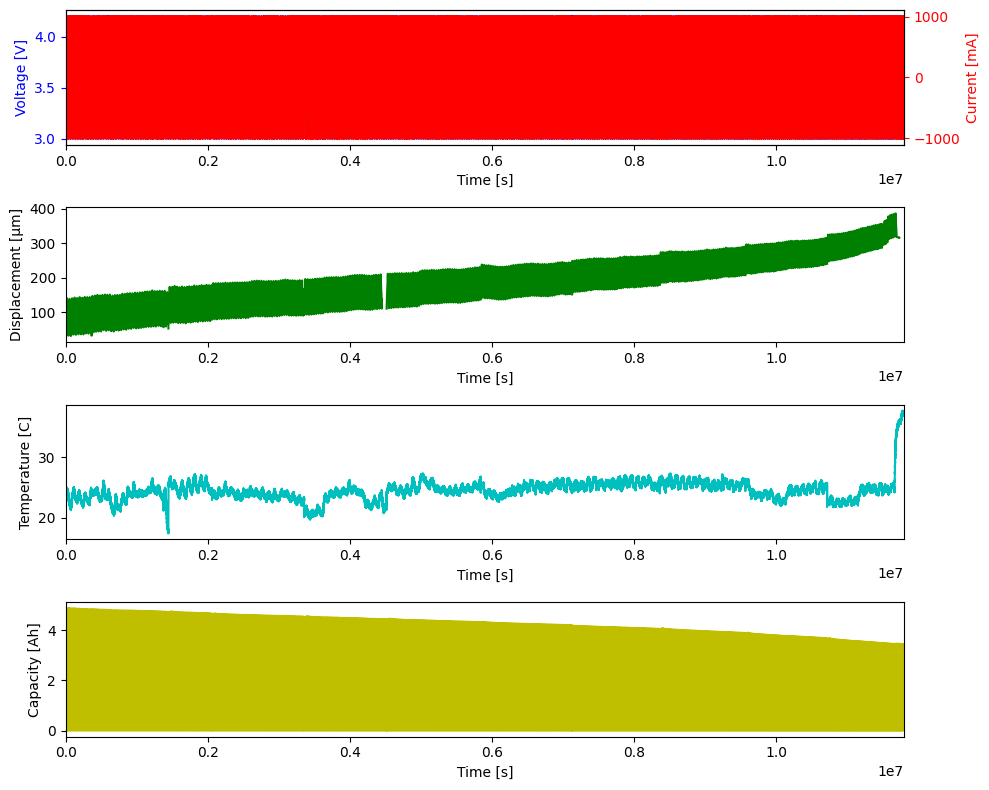

In [ ]:
##데이터셋 시각화
# 그래프 그리기
plt.figure(1, figsize=(10, 8))

# 첫 번째 서브플롯 (전압과 전류)
ax1 = plt.subplot(4, 1, 1)
ax1.plot(Time, Voltage, 'b-', linewidth=1.5)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlim([0, Time.iloc[-1]])

ax2 = ax1.twinx()
ax2.plot(Time, Current, 'r-', linewidth=1.5)
ax2.set_ylabel('Current [mA]', color='r')
ax2.tick_params('y', colors='r')
ax2.set_xlim([0, Time.iloc[-1]])

# 두 번째 서브플롯 (팽창)
plt.subplot(4, 1, 2)
plt.plot(Time, Expansion, 'g-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [μm]')
plt.xlim([0, Time.iloc[-1]])

# 세 번째 서브플롯 (온도)
plt.subplot(4, 1, 3)
plt.plot(Time, Temperature, 'c-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [C]')
plt.xlim([0, Time.iloc[-1]])


# 네 번째 서브플롯 (Capa)
plt.subplot(4, 1, 4)
plt.plot(Time, Capacity, 'y-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Capacity [Ah]')
plt.xlim([0, Time.iloc[-1]])

plt.tight_layout()
plt.show()

Time [s]                0
Current [mA]            0
Voltage [V]             0
Expansion [mu m]    13114
Temperature [C]         0
Q [Ah]                  0
Capacity [Ah]           0
Cycle number            0
dtype: int64


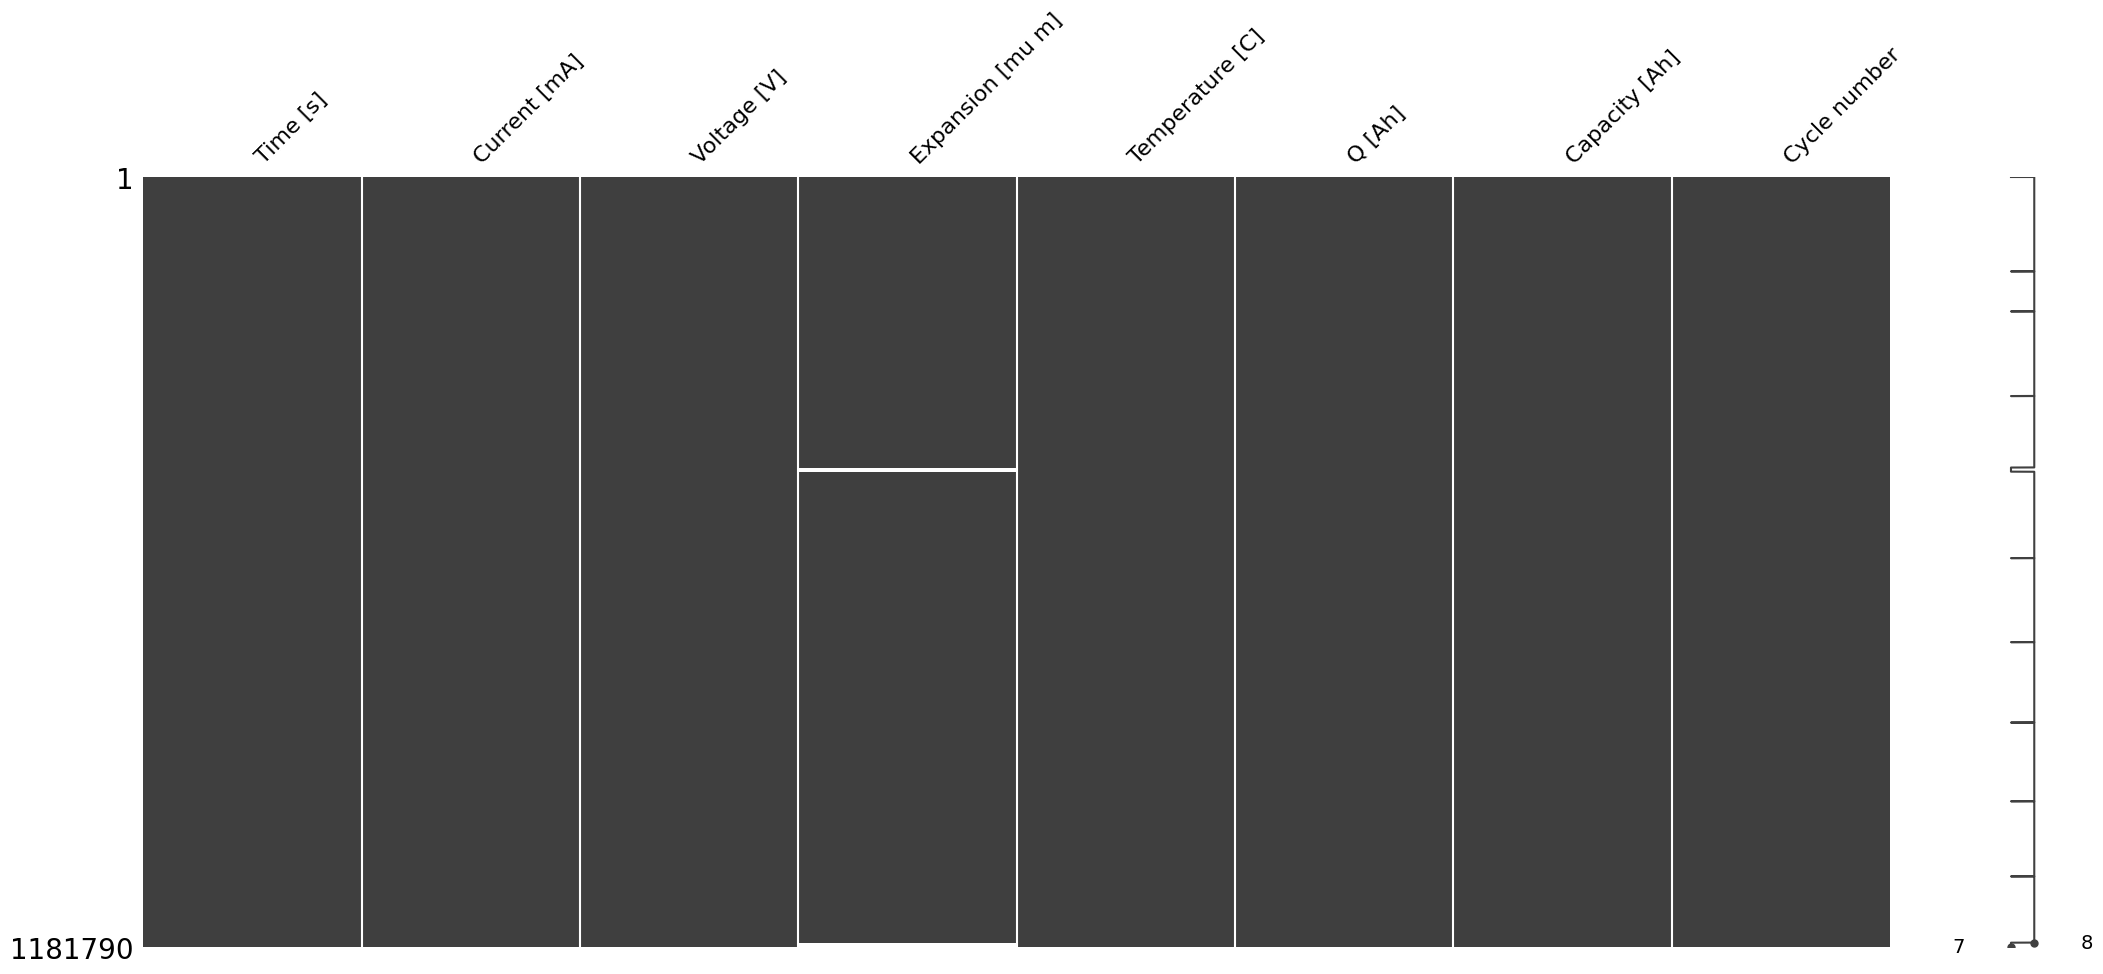

In [ ]:
##결측치 확인
import pandas as pd
import missingno as msno

# missingno 패키지의 matrix 함수를 사용하여 결측치를 시각화합니다.
msno.matrix(data)

#결측치 개수를 확인합니다
print(data.isnull().sum())

In [ ]:
# 각 열에서 결측치를 평균값으로 대체합니다.
data.fillna(data.mean(), inplace=True)
data

,Time [s],Current [mA],Voltage [V],Expansion [mu m],Temperature [C],Q [Ah],Capacity [Ah],Cycle number
0,0.000000e+00,0.00000,3.358494,192.499464,22.832777,0.000000,0.000000,0
1,1.000000e+01,0.00000,3.358455,32.400000,22.896147,0.000000,0.000000,0
2,2.000000e+01,0.00000,3.358416,32.400000,22.991203,0.000000,0.000000,0
3,2.999800e+01,0.00000,3.358494,32.469980,22.864462,0.000000,0.000000,0
4,3.999800e+01,1000.23750,3.384411,32.569980,22.785248,0.002751,0.002751,0
...,...,...,...,...,...,...,...,...
1181785,1.179725e+07,-999.77649,3.055138,192.499464,37.186234,0.413284,3.437950,379
1181786,1.179726e+07,-1001.45130,3.035878,192.499464,37.352581,0.410508,3.440727,379
1181787,1.179727e+07,-998.90955,3.013782,192.499464,37.376347,0.407731,3.443504,379
1181788,1.179728e+07,-999.75677,2.999997,192.499464,37.542694,0.406195,3.445039,379


from matplotlib import pyplot as plt
_df_0['Time [s]'].plot(kind='hist', bins=20, title='Time [s]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['Current [mA]'].plot(kind='hist', bins=20, title='Current [mA]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2['Voltage [V]'].plot(kind='hist', bins=20, title='Voltage [V]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['Expansion [mu m]'].plot(kind='hist', bins=20, title='Expansion [mu m]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_4.plot(kind='scatter', x='Time [s]', y='Current [mA]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_5.plot(kind='scatter', x='Current [mA]', y='Voltage [V]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6.plot(kind='scatter', x='Voltage [V]', y='Expansion [mu m]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7.plot(kind='scatter', x='Expansion [mu m]', y='Temperature [C]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Current [mA]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_8.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Current [mA]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Voltage [V]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_9.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Voltage [V]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Expansion [mu m]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_10.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Expansion [mu m]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Temperature [C]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_11.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Temperature [C]')

from matplotlib import pyplot as plt
_df_12['Time [s]'].plot(kind='line', figsize=(8, 4), title='Time [s]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_13['Current [mA]'].plot(kind='line', figsize=(8, 4), title='Current [mA]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_14['Voltage [V]'].plot(kind='line', figsize=(8, 4), title='Voltage [V]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_15['Expansion [mu m]'].plot(kind='line', figsize=(8, 4), title='Expansion [mu m]')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
#대체된 결측치 확인
print(data.isnull().sum())

Time [s]            0
Current [mA]        0
Voltage [V]         0
Expansion [mu m]    0
Temperature [C]     0
Q [Ah]              0
Capacity [Ah]       0
Cycle number        0
dtype: int64


In [ ]:
##데이터 변환
#시점 데이터 형태 실수로 바꾸기
data[timestamp_column] = pd.to_numeric(data[timestamp_column], errors='raise')

#종속변수인 'soh' 계산 및 추가
data['soh']=0
initial_value = data.iloc[3575, 6]
for i in range(len(data)):
  data.loc[i,'soh']=data.iloc[i,6]/initial_value

#예측에 쓰이는 모든 변수 설정
forecast_columns = list(data.columns[1:])

train_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=train_start_index,
    end_index=train_end_index,
)
eval_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=eval_start_index,
    end_index=eval_end_index,
)

print(data.head())

    Time [s]  Current [mA]  Voltage [V]  Expansion [mu m]  Temperature [C]  \
0   0.000000        0.0000     3.358494        192.499464        22.832777   
1  10.000000        0.0000     3.358455         32.400000        22.896147   
2  20.000001        0.0000     3.358416         32.400000        22.991203   
3  29.998001        0.0000     3.358494         32.469980        22.864462   
4  39.998002     1000.2375     3.384411         32.569980        22.785248   

     Q [Ah]  Capacity [Ah]  Cycle number       soh  
0  0.000000       0.000000             0  0.000000  
1  0.000000       0.000000             0  0.000000  
2  0.000000       0.000000             0  0.000000  
3  0.000000       0.000000             0  0.000000  
4  0.002751       0.002751             0  0.000562  


In [ ]:
#soh 동향 파악하기
print("최대 Capa at 초반 cycle :")
print(data['soh'][3575])
print(data['soh'][7169])
print("최대 Capa at 마지막 cycle:")
print(data['soh'][1176678])
print(data['soh'][1179236])

최대 Capa at 초반 cycle :
1.0
0.9953149215995805
최대 Capa at 마지막 cycle:
0.7058760667043491
0.7046975234741939


In [ ]:
#모델 설
tsp = TimeSeriesPreprocessor(
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]], #종속변수: soh
    control_columns=forecast_columns[:7], #독립변수: current, voltage 등 8가지
    scaling=True,
)
tsp.train(train_data)
train_dataset = ForecastDFDataset(
    tsp.preprocess(train_data),
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]], #종속변수: soh
    control_columns=forecast_columns[:7], #독립변수: current, voltage 등 8가지
    context_length=context_length,
    prediction_length=prediction_length,
)
eval_dataset = ForecastDFDataset(
    tsp.preprocess(eval_data),
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]], #종속변수: soh
    control_columns=forecast_columns[:7], #독립변수: current, voltage 등 8가지
    context_length=context_length,
    prediction_length=prediction_length,
)

In [ ]:
pred_config = PatchTSMixerConfig.from_pretrained(
    pretrained_model_path,
    context_length=context_length,
    num_input_channels=tsp.num_input_channels,
    prediction_length=prediction_length,
    do_mask_input=False
)

In [ ]:
#사전학습된 모델 불러오기
forecasting_model = PatchTSMixerForPrediction.from_pretrained(
    "/content/drive/MyDrive/data01/best_model",
    config=pred_config,
    ignore_mismatched_sizes=True,
)

In [ ]:
#모델 학습
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/data01/checkpoints/forecast",
    per_device_train_batch_size=8,  # defaults to 8
    per_device_eval_batch_size=64,  # defaults to 8
    num_train_epochs=1,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=5,
    logging_strategy="epoch",
    load_best_model_at_end=True,
    max_steps=10,  # For a quick test
    label_names=["future_values"],
)

forecasting_trainer = Trainer(
    model=forecasting_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
)
#미세조정된 모델 저장
forecasting_trainer.train()
forecasting_trainer.save_model("/content/drive/MyDrive/data01/model/forecasting")
tsp.save_pretrained("preprocessor")

max_steps is given, it will override any value given in num_train_epochs


Epoch,Training Loss,Validation Loss
0,0.062200,0.086395


['preprocessor/preprocessor_config.json']

#5) 새로운 데이터셋으로 전이학습

In [ ]:
import pandas as pd
from transformers.models.patchtsmixer import PatchTSMixerForPrediction
from tsfm_public.toolkit.time_series_forecasting_pipeline import (
    TimeSeriesForecastingPipeline,
)
from tsfm_public.toolkit.time_series_preprocessor import TimeSeriesPreprocessor
from tsfm_public.toolkit.util import select_by_index
from tsfm_public.toolkit.visualization import plot_ts_forecasting

In [ ]:
timestamp_column = 'Time [s]'
id_columns = []
#forecast_columns = ['Current [mA]', 'Voltage [V]', 'Expansion [mu m]', 'Temperature [C]', 'Q [Ah]', 'Capacity [Ah]', 'Cycle number', 'soh'] # for 파인튜닝+예측. 분리 시 주석 빼기
finetuned_model_path = ("/content/drive/MyDrive/data01/model/forecasting")

In [ ]:
model = PatchTSMixerForPrediction.from_pretrained(finetuned_model_path)
# model.model.mask_input = False
forecast_pipeline = TimeSeriesForecastingPipeline(
    model=model,
    timestamp_column=timestamp_column,
    id_columns=id_columns,
    target_columns=[forecast_columns[7]],
    control_columns=forecast_columns[:7],
)
context_length = model.config.context_length

tsp = TimeSeriesPreprocessor.from_pretrained("preprocessor")

In [ ]:
#다른 데이터셋
dataset_path ="/content/drive/MyDrive/02/cycling_wExpansion.csv"
test_start_index = 12 * 30 * 24 + 4 * 30 * 24 - context_length
test_end_index = 12 * 30 * 24 + 8 * 30 * 24

In [ ]:
# 새로운 데이터 불러오기
data = pd.read_csv(dataset_path, header=0)

data[timestamp_column] = pd.to_numeric(data[timestamp_column], errors='raise')

#data=data.iloc[:10000] # for 데이터 개형 확인
print(data.columns)
# 데이터 분리
Time = data.iloc[:, 0]  # Time in seconds
Current = data.iloc[:, 1]  # Current in mA
Voltage = data.iloc[:, 2]  # Voltage in V
Expansion = data.iloc[:, 3]  # Expansion in mu m
Temperature = data.iloc[:, 4]  # Temperature in C
Q = data.iloc[:, 5]  # Q in Ah
Capacity = data.iloc[:, 6]  # Capacity in A.h
cycle_number = data.iloc[:, 7]

print(data.head)

Index(['Time [s]', 'Current [mA]', 'Voltage [V]', 'Expansion [mu m]',
       'Temperature [C]', 'Q [Ah]', 'Capacity [Ah]', 'Cycle number'],
      dtype='object')
<bound method NDFrame.head of             Time [s]  Current [mA]  Voltage [V]  Expansion [mu m]  \
0       0.000000e+00        0.0000     4.171435               NaN   
1       1.000000e+01        0.0000     4.171317        107.500000   
2       2.000000e+01        0.0000     4.171435        107.500000   
3       2.999800e+01        0.0000     4.171356        107.500000   
4       3.999800e+01     1000.2375     4.197864        107.559980   
...              ...           ...          ...               ...   
901555  8.999717e+06     1000.2375     3.786470        182.500000   
901556  8.999727e+06     1000.1981     3.786745        182.503641   
901557  8.999737e+06     1000.2572     3.787061        182.600000   
901558  8.999747e+06     1000.1586     3.787297        182.600000   
901559  8.999756e+06     1000.1784     3.787612  

In [ ]:
#충전이 시작되는 시점 파악
Capacity.index[Capacity < 0.001].tolist()

[0,
 1,
 2,
 3,
 1656,
 4950,
 8242,
 11530,
 14816,
 18098,
 21376,
 24656,
 27933,
 31210,
 34485,
 37758,
 41031,
 44300,
 47569,
 50836,
 54103,
 57369,
 60635,
 61014,
 61015,
 61016,
 61017,
 64445,
 67729,
 71004,
 74274,
 77545,
 80813,
 84079,
 87343,
 90606,
 93867,
 97126,
 100386,
 103643,
 106901,
 110158,
 113415,
 116672,
 119926,
 123179,
 126433,
 129687,
 132939,
 136192,
 139443,
 142694,
 145942,
 146054,
 146055,
 146056,
 146057,
 149437,
 152699,
 155956,
 159209,
 162458,
 165705,
 168949,
 172194,
 175438,
 175469,
 175470,
 175471,
 175472,
 177269,
 180519,
 183763,
 187005,
 190242,
 193476,
 196709,
 199938,
 203166,
 206392,
 209616,
 212839,
 216059,
 219277,
 222496,
 225716,
 228933,
 232151,
 233376,
 233377,
 233378,
 233379,
 236704,
 239946,
 243181,
 246412,
 249640,
 252866,
 256089,
 259306,
 262526,
 265743,
 268959,
 272173,
 275387,
 278599,
 281807,
 285015,
 288222,
 291429,
 294636,
 297841,
 299768,
 299769,
 299770,
 299771,
 303075,
 306

In [ ]:
print("최대 Capa at 초반 cycle :")
print(Capacity[1655])
print(Capacity[1656])
print(Capacity[4949])
print(Capacity[4950])
print("최대 Capa at 마지막 cycle:")
print(Capacity[898025])
print(Capacity[898026])
print(Capacity[901020])
print(Capacity[901021])

최대 Capa at 초반 cycle :
4.32934843463438
2.58314344618056e-10
4.31218661382802
1.92633734809028e-10
최대 Capa at 마지막 cycle:
3.81889107067441
1.48857964409722e-10
3.81854328281338
1.26987033420139e-10


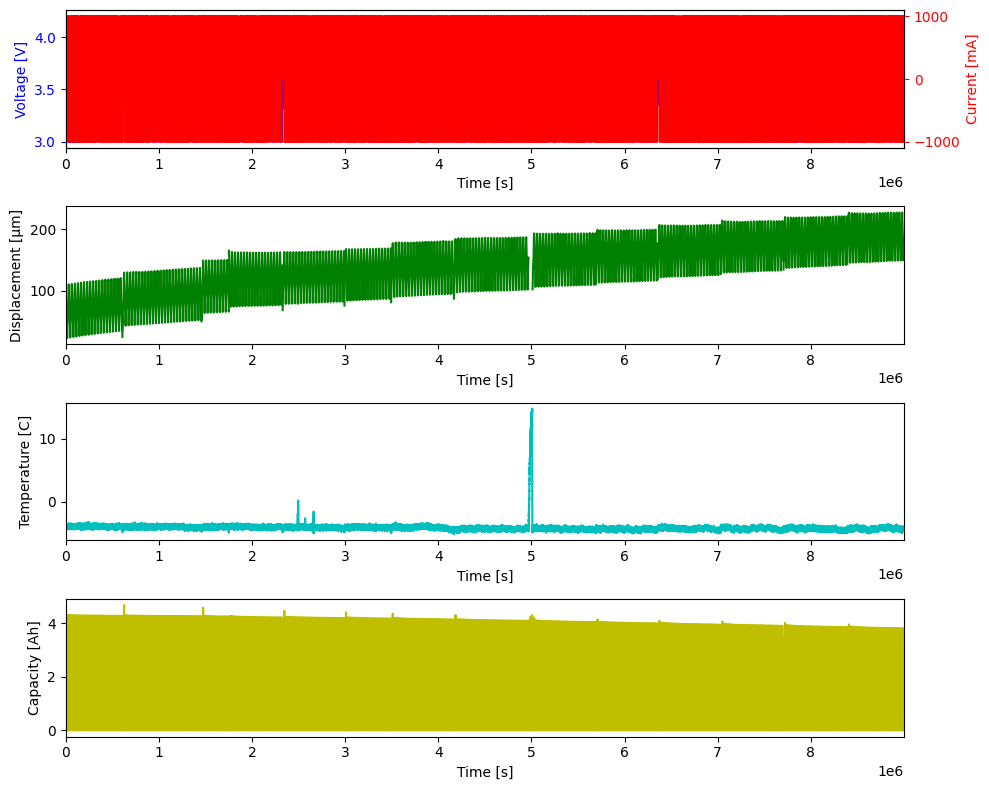

In [ ]:
##데이터셋 시각화
# 그래프 그리기
plt.figure(1, figsize=(10, 8))

# 첫 번째 서브플롯 (전압과 전류)
ax1 = plt.subplot(4, 1, 1)
ax1.plot(Time, Voltage, 'b-', linewidth=1.5)
ax1.set_xlabel('Time [s]')
ax1.set_ylabel('Voltage [V]', color='b')
ax1.tick_params('y', colors='b')
ax1.set_xlim([0, Time.iloc[-1]])

ax2 = ax1.twinx()
ax2.plot(Time, Current, 'r-', linewidth=1.5)
ax2.set_ylabel('Current [mA]', color='r')
ax2.tick_params('y', colors='r')
ax2.set_xlim([0, Time.iloc[-1]])

# 두 번째 서브플롯 (팽창)
plt.subplot(4, 1, 2)
plt.plot(Time, Expansion, 'g-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Displacement [μm]')
plt.xlim([0, Time.iloc[-1]])

# 세 번째 서브플롯 (온도)
plt.subplot(4, 1, 3)
plt.plot(Time, Temperature, 'c-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Temperature [C]')
plt.xlim([0, Time.iloc[-1]])


# 네 번째 서브플롯 (Capa)
plt.subplot(4, 1, 4)
plt.plot(Time, Capacity, 'y-', linewidth=1.5)
plt.xlabel('Time [s]')
plt.ylabel('Capacity [Ah]')
plt.xlim([0, Time.iloc[-1]])

plt.tight_layout()
plt.show()

Time [s]               0
Current [mA]           0
Voltage [V]            0
Expansion [mu m]    4384
Temperature [C]        0
Q [Ah]                 0
Capacity [Ah]          0
Cycle number           0
dtype: int64


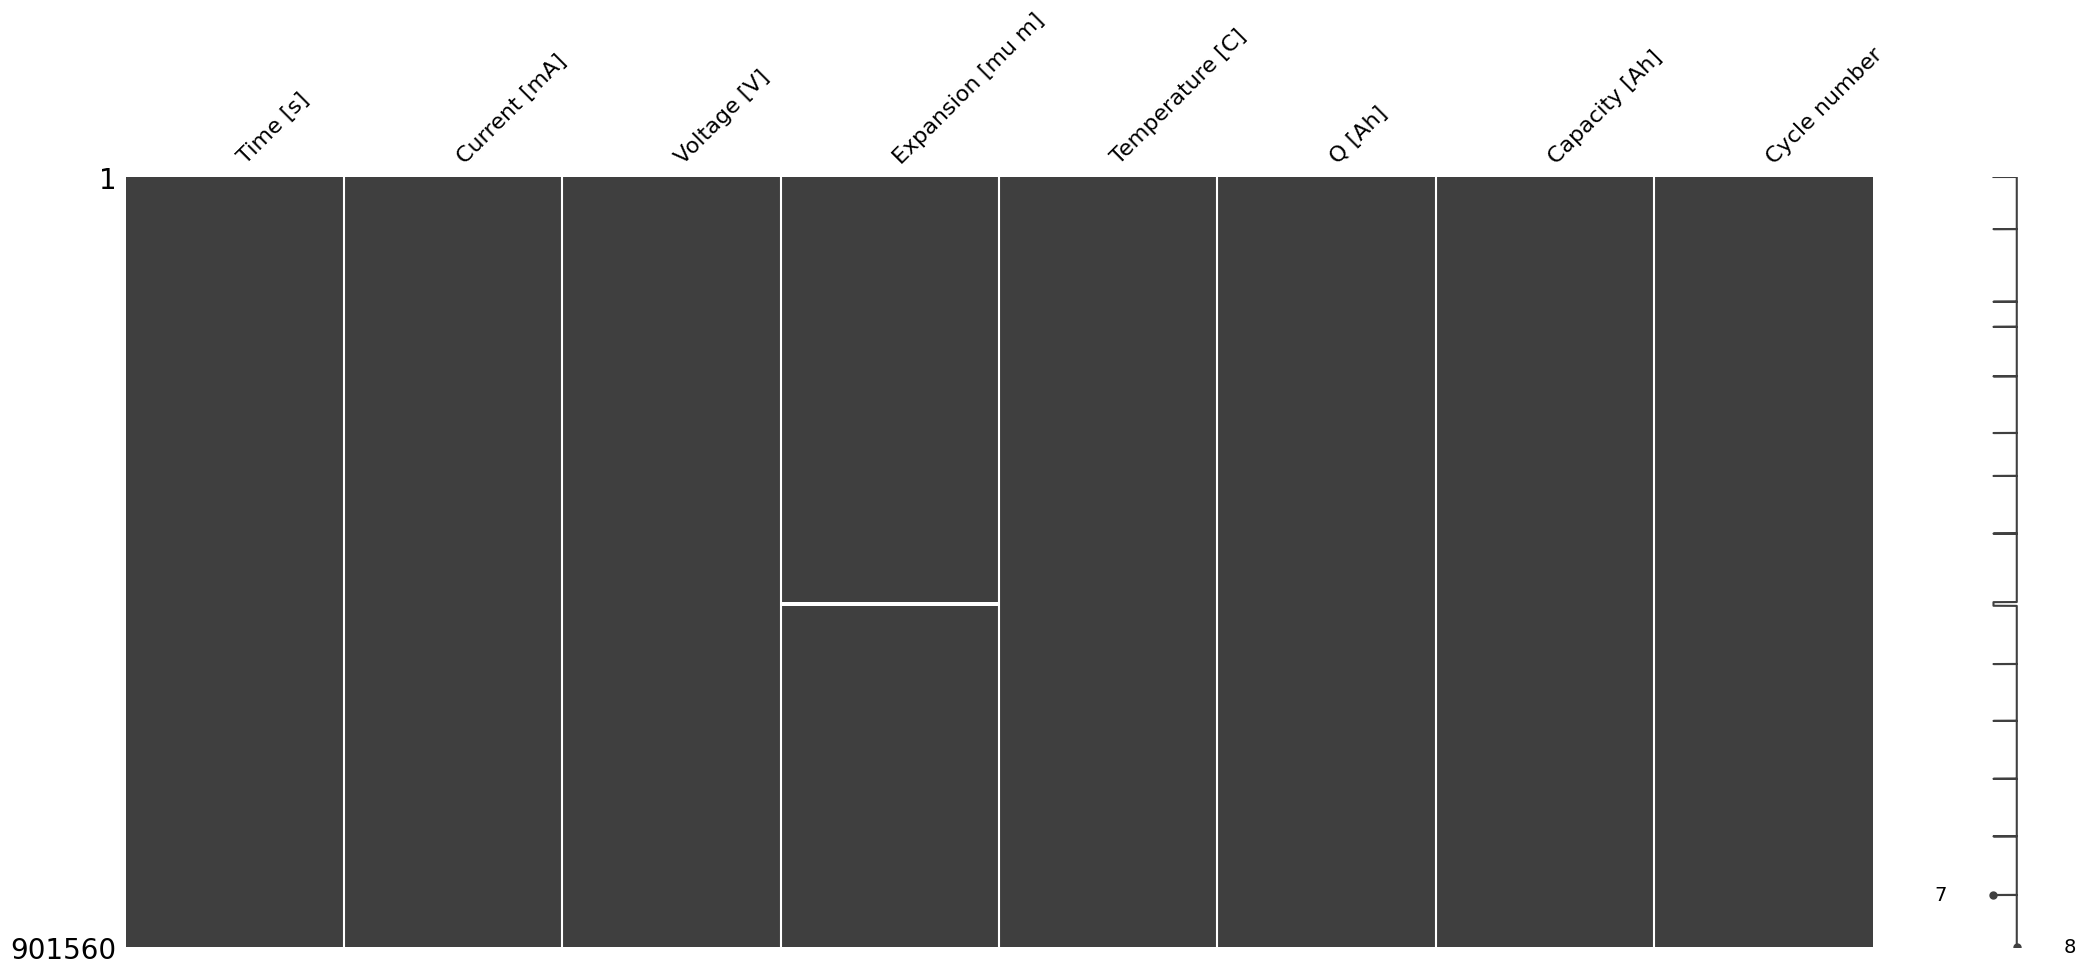

In [ ]:
##결측치 확인
import pandas as pd
import missingno as msno

# missingno 패키지의 matrix 함수를 사용하여 결측치를 시각화합니다.
msno.matrix(data)

#결측치 개수를 확인합니다
print(data.isnull().sum())

In [ ]:
# 각 열에서 결측치를 평균값으로 대체합니다.
data.fillna(data.mean(), inplace=True)
data

,Time [s],Current [mA],Voltage [V],Expansion [mu m],Temperature [C],Q [Ah],Capacity [Ah],Cycle number
0,0.000000e+00,0.0000,4.171435,142.017078,-4.923577,0.000000,0.000000,0
1,1.000000e+01,0.0000,4.171317,107.500000,-4.844364,0.000000,0.000000,0
2,2.000000e+01,0.0000,4.171435,107.500000,-4.646330,0.000000,0.000000,0
3,2.999800e+01,0.0000,4.171356,107.500000,-4.812678,0.000000,0.000000,0
4,3.999800e+01,1000.2375,4.197864,107.559980,-4.749308,0.002750,0.002750,0
...,...,...,...,...,...,...,...,...
901555,8.999717e+06,1000.2375,3.786470,182.500000,-4.139365,1.660565,1.483650,293
901556,8.999727e+06,1000.1981,3.786745,182.503641,-4.218578,1.663343,1.486428,293
901557,8.999737e+06,1000.2572,3.787061,182.600000,-4.068073,1.666122,1.489207,293
901558,8.999747e+06,1000.1586,3.787297,182.600000,-4.289871,1.668900,1.491985,293


from matplotlib import pyplot as plt
data['Time [s]'].plot(kind='hist', bins=20, title='Time [s]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['Current [mA]'].plot(kind='hist', bins=20, title='Current [mA]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['Voltage [V]'].plot(kind='hist', bins=20, title='Voltage [V]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data['Expansion [mu m]'].plot(kind='hist', bins=20, title='Expansion [mu m]')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Time [s]', y='Current [mA]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Current [mA]', y='Voltage [V]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Voltage [V]', y='Expansion [mu m]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
data.plot(kind='scatter', x='Expansion [mu m]', y='Temperature [C]', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Current [mA]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Current [mA]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Voltage [V]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Voltage [V]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Expansion [mu m]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Expansion [mu m]')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Time [s]']
  ys = series['Temperature [C]']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = data.sort_values('Time [s]', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Time [s]')
_ = plt.ylabel('Temperature [C]')

from matplotlib import pyplot as plt
data['Time [s]'].plot(kind='line', figsize=(8, 4), title='Time [s]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['Current [mA]'].plot(kind='line', figsize=(8, 4), title='Current [mA]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['Voltage [V]'].plot(kind='line', figsize=(8, 4), title='Voltage [V]')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
data['Expansion [mu m]'].plot(kind='line', figsize=(8, 4), title='Expansion [mu m]')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
print(data.isnull().sum())

Time [s]            0
Current [mA]        0
Voltage [V]         0
Expansion [mu m]    0
Temperature [C]     0
Q [Ah]              0
Capacity [Ah]       0
Cycle number        0
dtype: int64


In [ ]:
#종속변수 'soh' 추가하기
data['soh']=0
initial_value = data.iloc[1655, 6]
for i in range(len(data)):
  data.loc[i,'soh']=data.iloc[i,6]/initial_value

forecast_columns = list(data.columns[1:])

In [ ]:
print("최대 Capa at 초반 cycle :")
print(data['soh'][1655])
print(data['soh'][4949])
print("최대 Capa at 마지막 cycle:")
print(data['soh'][898025])
print(data['soh'][901020])

최대 Capa at 초반 cycle :
1.0
0.996035934490958
최대 Capa at 마지막 cycle:
0.8820937211067701
0.8820133884963828


In [ ]:
test_data = select_by_index(
    data,
    id_columns=id_columns,
    start_index=test_start_index,
    end_index=test_end_index,
)
test_data = tsp.preprocess(test_data)

#6) 예측하기

In [ ]:
#예측 시작
forecasts = forecast_pipeline(test_data)
forecasts.head()

,Time [s],soh_prediction,soh
0,1970-01-01 00:00:00.000115009,"[1.725489854812622, 1.726333737373352, 1.72788...","[1.7333335876464844, 1.7355704307556152, 1.737..."
1,1970-01-01 00:00:00.000115019,"[1.7277270555496216, 1.7285709381103516, 1.730...","[1.7355704307556152, 1.737807273864746, 1.7400..."
2,1970-01-01 00:00:00.000115029,"[1.729964017868042, 1.7308080196380615, 1.7323...","[1.737807273864746, 1.7400442361831665, 1.7422..."
3,1970-01-01 00:00:00.000115039,"[1.7322005033493042, 1.7330443859100342, 1.734...","[1.7400442361831665, 1.7422810792922974, 1.744..."
4,1970-01-01 00:00:00.000115049,"[1.7344379425048828, 1.7352819442749023, 1.736...","[1.7422810792922974, 1.7445179224014282, 1.746..."


In [ ]:
#예측 결과 시각화
plot_ts_forecasting(
    test_data,
    forecasts,
    forecast_columns=["soh"],
    timestamp_column=timestamp_column,
    periodicity="1s",
    prediction_length=model.config.prediction_length,
    context_length=context_length,
    plot_start=0,
    plot_end=context_length + model.config.prediction_length * 3,
    num_predictions=3,
    plot_stride=model.config.prediction_length,
    title="Forecast",
    fig_size=(1100, 600),
    plot_type="plotly",
    return_image=False,
)